<a href="https://colab.research.google.com/github/homenf/computer-vision/blob/master/Assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc
from IPython.display import Image as Img

In [28]:
def PIL_to_arr(im):
  im_array = np.asarray(im)
  return im_array.astype('float64')

# open and convert to an image array
def open_and_convert(name, toGrey=False):
  im = Image.open(name)
  if toGrey:
    im = im.convert('L')
  return PIL_to_arr(im)

def arr_to_PIL(arr):
  oldarr = arr
  arr = np.clip(np.array(arr), a_min = 0, a_max = 255)
  arr = arr.astype('uint8')
  return Image.fromarray(arr)

def greyscaleToRGB(im):
  X, Y = im.size
  canvas = Image.new("RGB", (X, Y), (255, 255, 255))
  canvas.paste(im, (0, 0))
  return canvas
  
# convert and image array and save
def save_and_display(im, name):
  im.save(name + '.png') 
  display(Img(name + '.png'))

In [32]:
import scipy
# part 1.2
def MakeGaussianPyramid(im, scale, minsize):
   pyramid = []
   X, Y = im.size
   pyramid.append(im)
   while (minsize < X or minsize < Y):
    arr = scipy.ndimage.gaussian_filter(im, 1/(2 * scale)) # this auto converts im to numpy array
    im = arr_to_PIL(arr)
    im = im.resize((int(0.75 * X), int(0.75 * Y)), Image.BICUBIC) 
    X, Y = im.size
    pyramid.append(im)
   return pyramid

# execute 1.2
im = Image.open("tree.jpg")
pyramid = MakeGaussianPyramid(im, 0.75, 50)

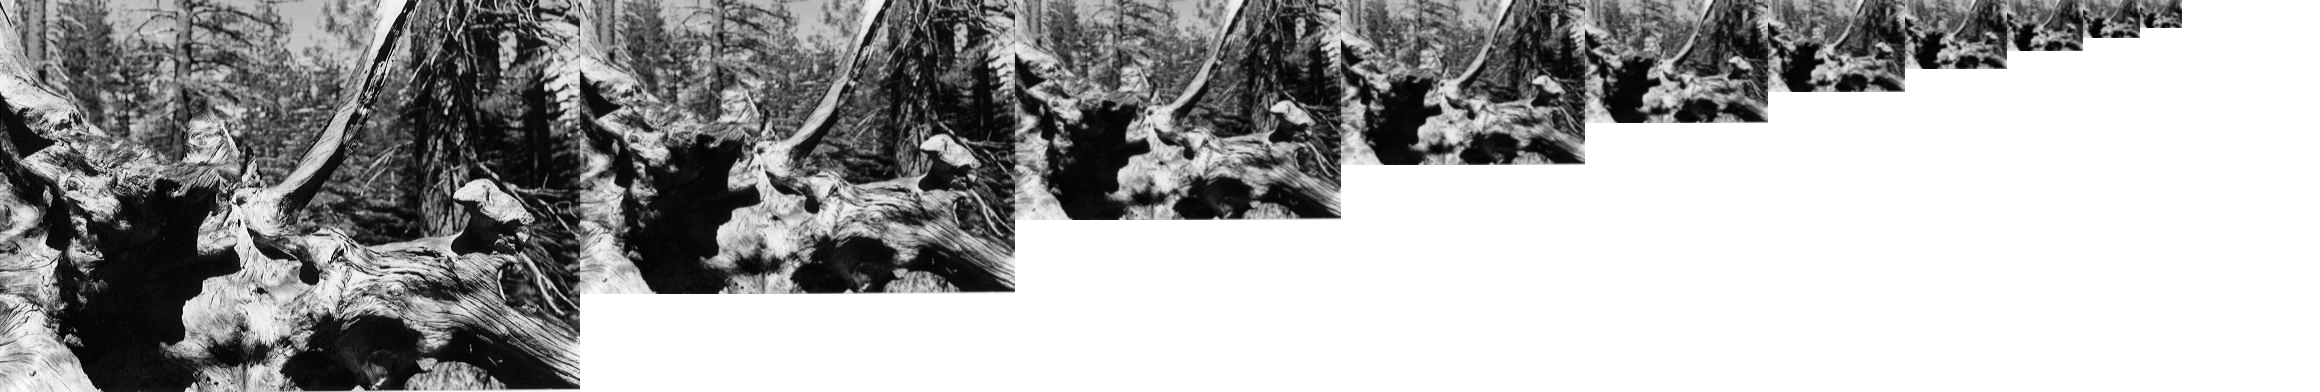

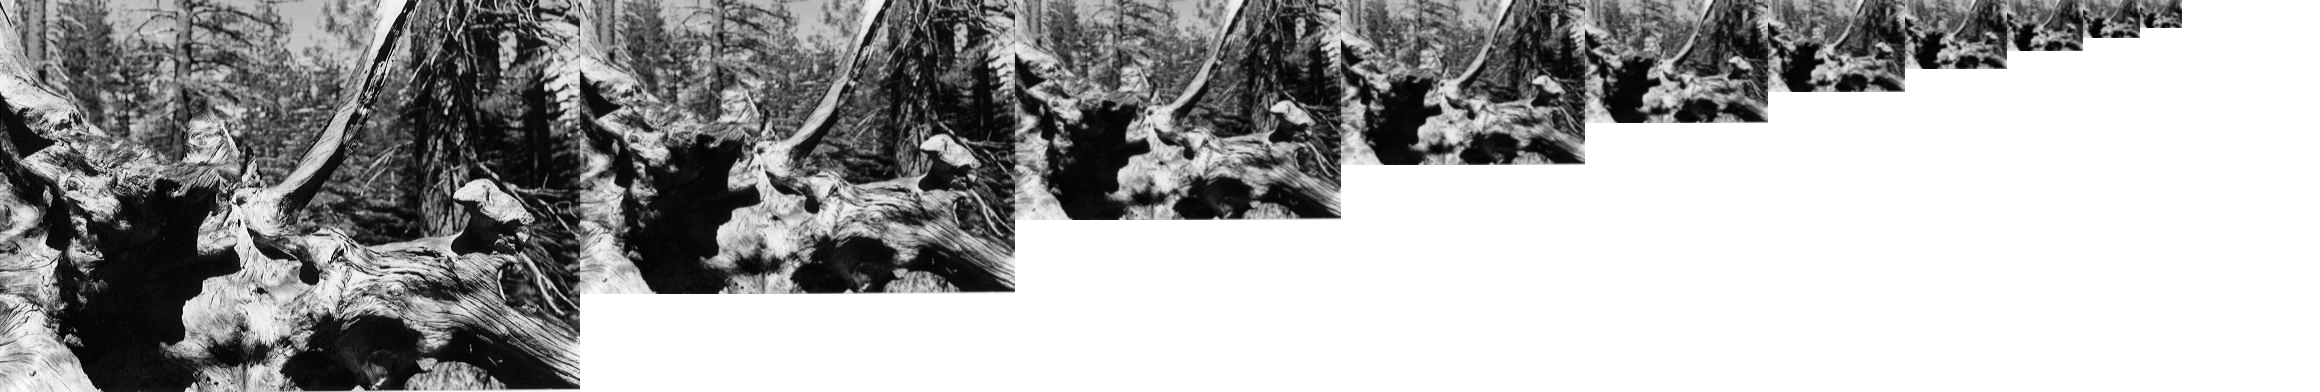

In [5]:
# part 1.3
# color can be "L" or "RGB" 
def showGaussianPyramid(pyramid, rgb=True):
  firstX, firstY = pyramid[0].size
  if (rgb):
    canvas = Image.new("RGB", (4 * firstX, firstY), (255, 255, 255)) # geometric sum --> 4
  else:
    canvas = Image.new("L", (4 * firstX, firstY), 255) # geometric sum --> 4
  currX = 0
  for im in pyramid:
    X, Y = im.size
    canvas.paste(im, (currX, 0))
    currX += X
  save_and_display(canvas, "canvas")

#execute 1.3 
showGaussianPyramid(pyramid, "L")
showGaussianPyramid(pyramid)

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


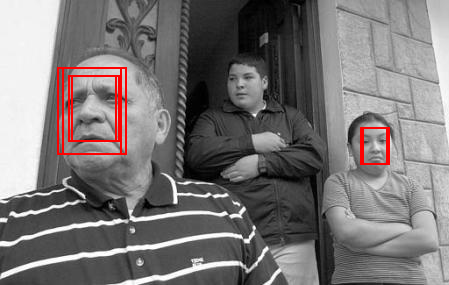

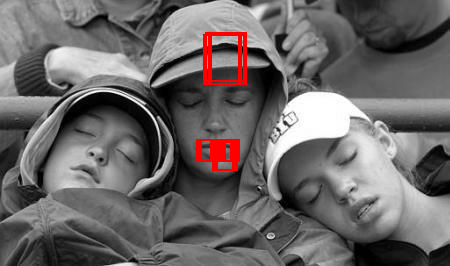

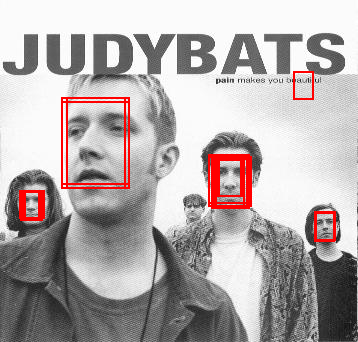

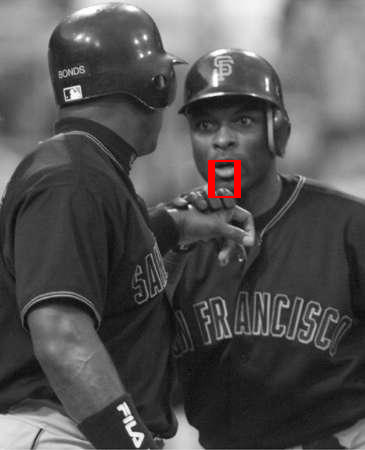

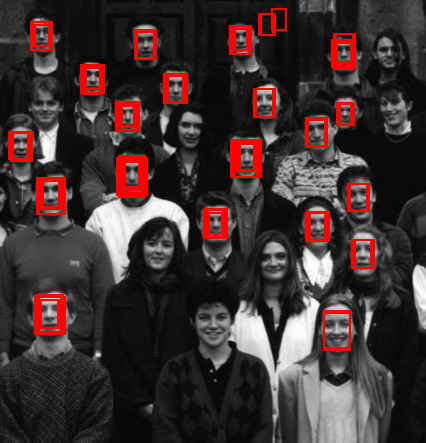

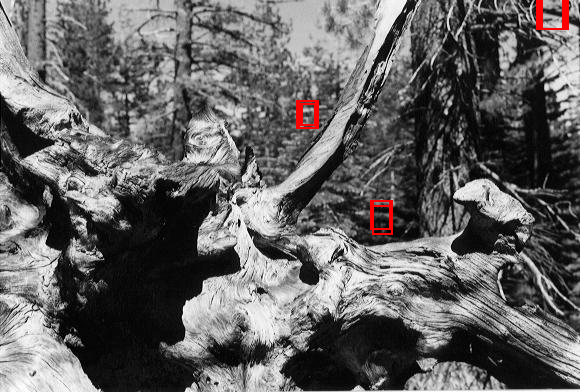

In [102]:
# part 1.4
def findTemplate(pyramid, template, threshold):
  canvas = pyramid[0].copy().convert('RGB')
  cX, cY = canvas.size
  # print("cx, cy", cX, cY)
  tX, tY = template.size
  # print("tx, ty", tX, tY)
  tx = 15
  ty = int(tx/tX * tY)
  template = template.resize((tx, ty), Image.BICUBIC)
  for im in pyramid:
    X, Y = im.size
    ratio = cX / X
    heatmap = ncc.normxcorr2D(im, template)
    # print(heatmap.shape) the heatmap has x and y flipped
    for j in range(Y):
      for i in range(X):
        if abs(heatmap[j][i]) > threshold:
          canvas = drawBox(canvas, i, j, tx, ty, ratio)
  return canvas

# draw a box at the original image, according to the ratio  
def drawBox(canvas, x, y, tx, ty, ratio):
  draw = ImageDraw.Draw(canvas)
  x1 = int(x * ratio - (tx * ratio) / 2)
  x2 = int(x * ratio + (tx * ratio) / 2)
  y1 = int(y * ratio - (ty * ratio) / 2)
  y2 = int(y * ratio + (ty * ratio) / 2)
  draw.line((x1, y1, x1, y2),fill="red", width=2)
  draw.line((x1, y2, x2, y2),fill="red", width=2)
  draw.line((x2, y2, x2, y1),fill="red", width=2)
  draw.line((x2, y1, x1, y1),fill="red", width=2)
  del draw
  return canvas

#execute 1.4
l_im = ["family", "fans", "judybats", "sports", "students", "tree"]
for im in l_im:
  im = Image.open(im + ".jpg")
  pyramid = MakeGaussianPyramid(im, 0.75, 50)
  template = Image.open("template.jpg")
  threshold = 0.615 
  canvas = findTemplate(pyramid, template, threshold)
  save_and_display(canvas, "marked")

Threshold: 61.5% \\
Recall rate:  \\
 ["family: 67%", "fans: 0%", "judybats: 80%", "sports: 0%", "students: 74%", "tree: N/A"] \\
Some images, such as "sports" and "fans", have low recall rate because they are close-up shots and people are wearing hoodies or helmets, or the edge of their face has a similar color as the background.

**Part 2** \\
Make Laplacian

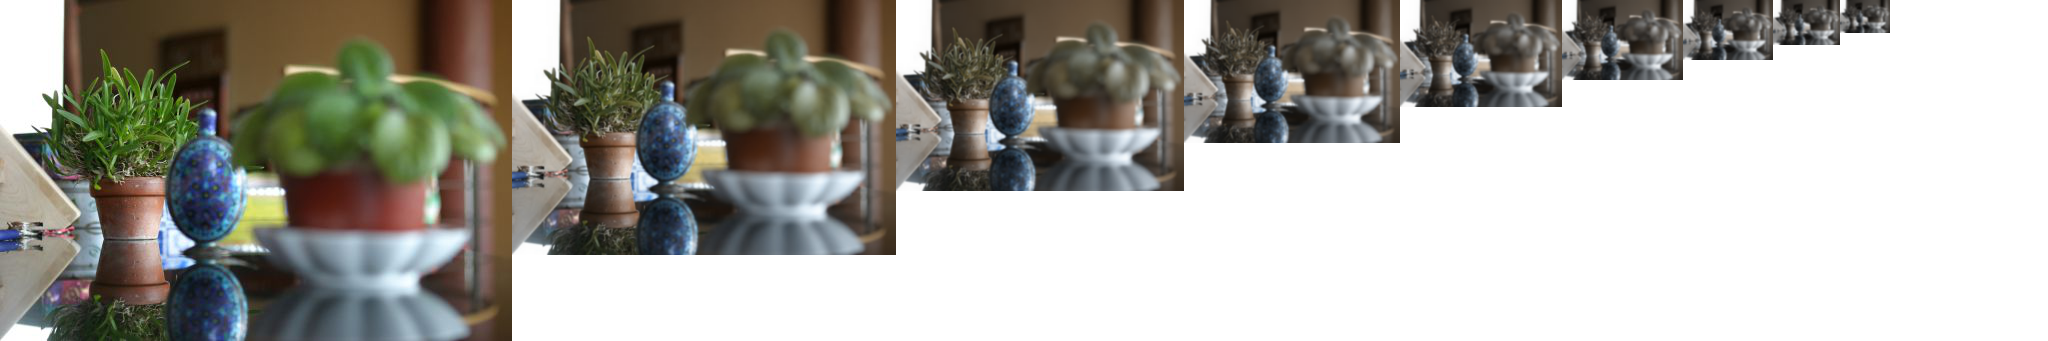

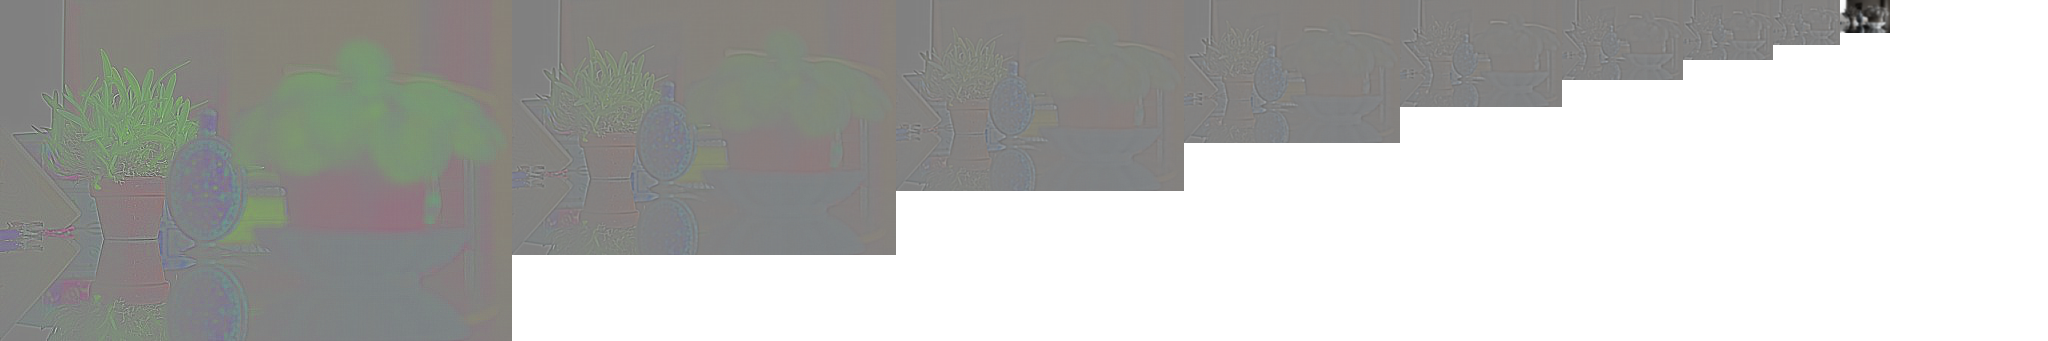

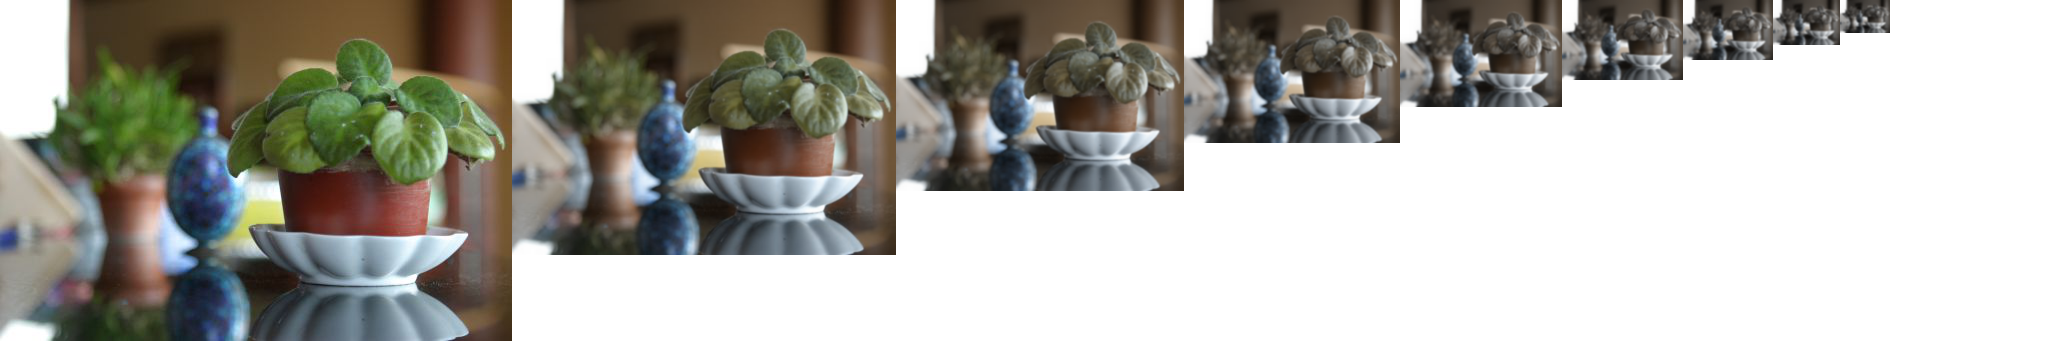

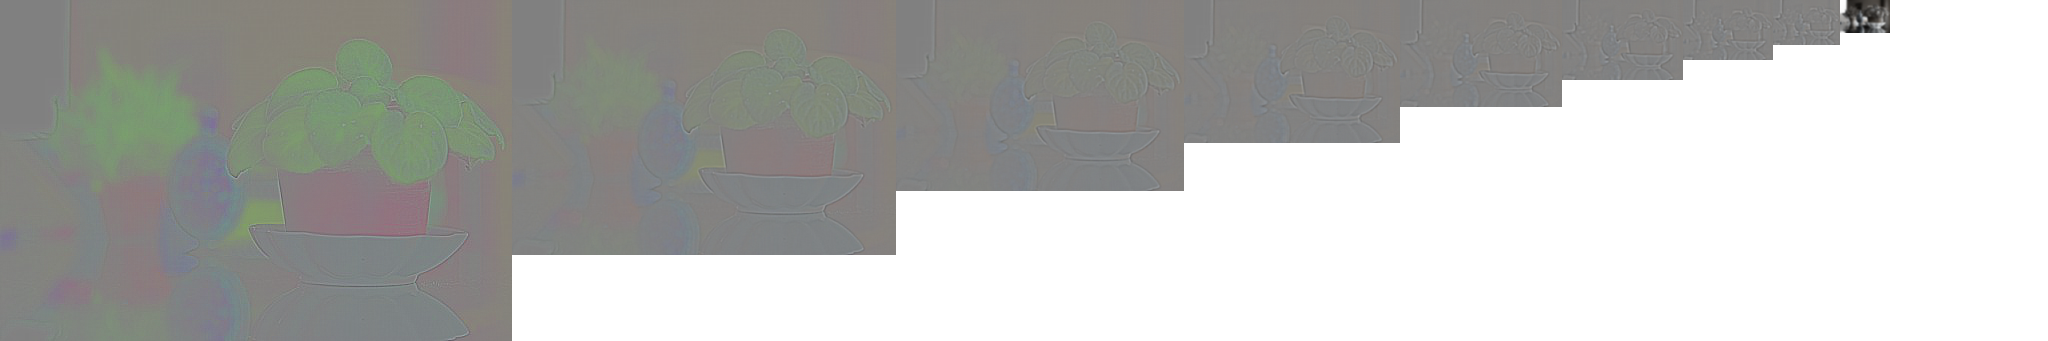

In [15]:
#part 2.2
def makeLaplacianPyramid(im, scale, minsize):
  gaussian = MakeGaussianPyramid(im, scale, minsize)
  showGaussianPyramid(gaussian)
  laplacian = [] # ndarr of element (width, height, rgb)
  for i in range(len(gaussian) - 1):
    small = gaussian[i+1]
    big = gaussian[i]
    X, Y = big.size
    resized_big = small.resize((X, Y), Image.BICUBIC)
    lap_arr = PIL_to_arr(gaussian[i]) - PIL_to_arr(resized_big)
    laplacian.append(lap_arr)
  laplacian.append(PIL_to_arr(gaussian[len(gaussian) - 1]))
  return laplacian

#part 2.3
def showLaplacianPyramid(pyramid, rgb=True):
  firstY, firstX, rgb = np.shape(pyramid[0])
  canvas = Image.new("RGB", (4 * firstX, firstY), (255, 255, 255)) # geometric sum --> 4
  currX = 0
  for i in range(len(pyramid)):
    im_arr = pyramid[i]
    Y, X, rgb = np.shape(im_arr)
    if i != len(pyramid) - 1: # if not the last
      im = arr_to_PIL(im_arr + 128)
    else:
      im = arr_to_PIL(im_arr)
    X, Y = im.size
    canvas.paste(im, (currX, 0))
    currX += X
  save_and_display(canvas, "canvas")

#execute 2.2, 2.3
test_images = ["orchid", "violet"]
for name in test_images:
  im = Image.open(name + ".jpg")
  scale = 0.75
  minsize = 50
  laplacian = makeLaplacianPyramid(im, scale, minsize)
  showLaplacianPyramid(laplacian)

Reconstruct Gaussian from Laplacian

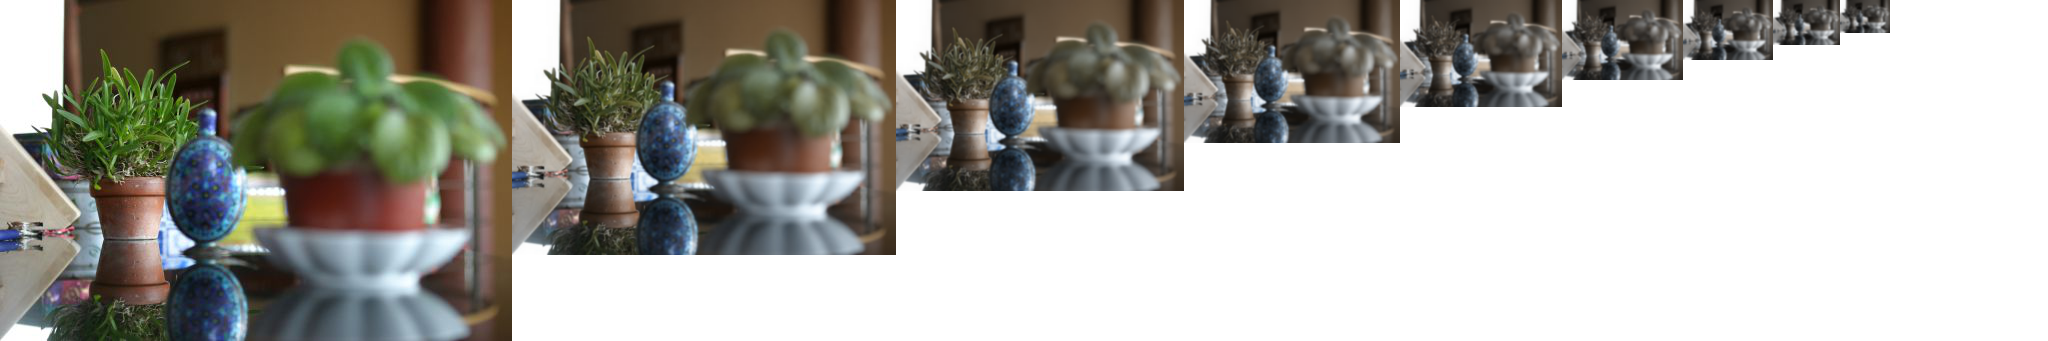

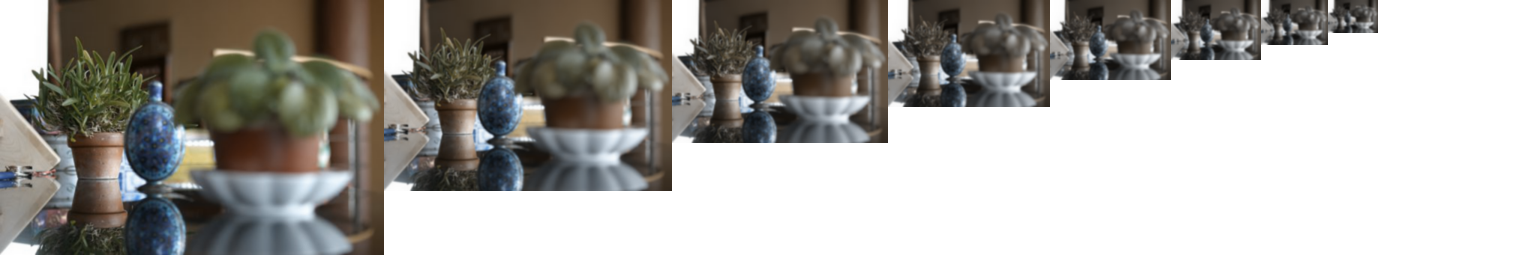

In [33]:
# part 2.4
def reconstruct_big(small, residual):
  Y, X, rgb = np.shape(residual) # X, Y is flipped
  blurred = small.resize((X, Y), Image.BICUBIC)
  big = PIL_to_arr(blurred) + residual
  return arr_to_PIL(big)

def reconstruct_big_test(small, residual):
  Y, X, rgb = np.shape(residual) # X, Y is flipped
  blurred = small.resize((X, Y), Image.BICUBIC)
  big = PIL_to_arr(blurred)
  return arr_to_PIL(big)

def reconstructGaussianFromLaplacianPyramid(lPyramid):
  lPyramid.reverse()
  gaussian = []
  currGauss = arr_to_PIL(lPyramid [0])
  for i in range(len(lPyramid) - 1):
    gaussian.append(currGauss)
    currGauss = reconstruct_big(currGauss, lPyramid[i+1])
  gaussian.reverse()
  showGaussianPyramid(gaussian)

# execute 2.4
im = Image.open("orchid" + ".jpg")
scale = 0.75
minsize = 50
laplacian = makeLaplacianPyramid(im, scale, minsize)
reconstructGaussianFromLaplacianPyramid(laplacian)

Blending

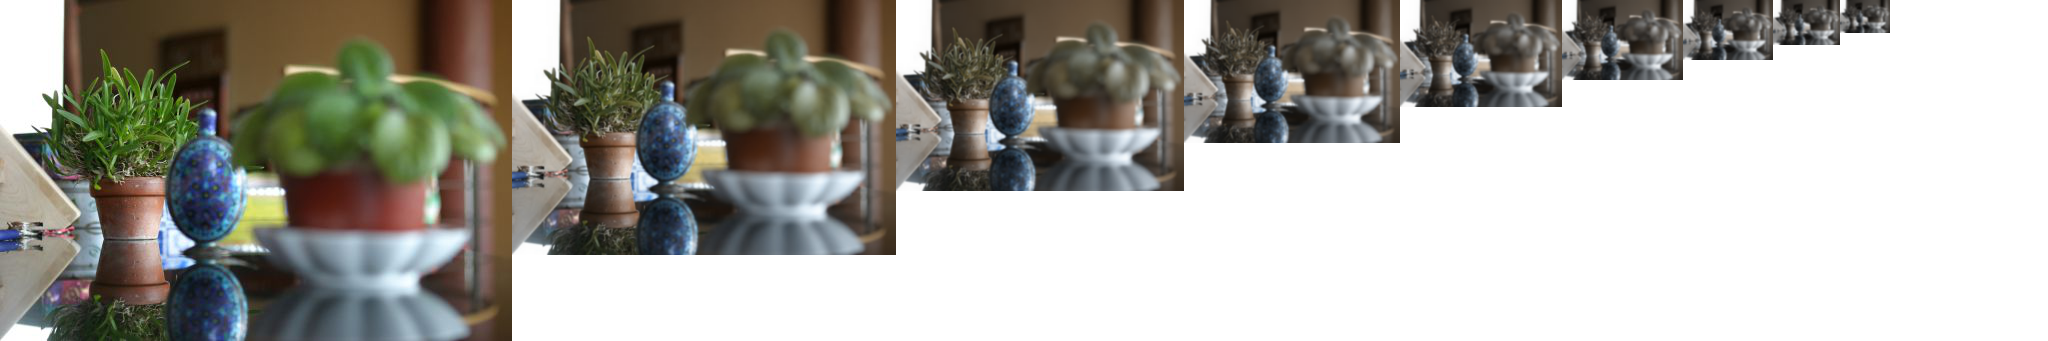

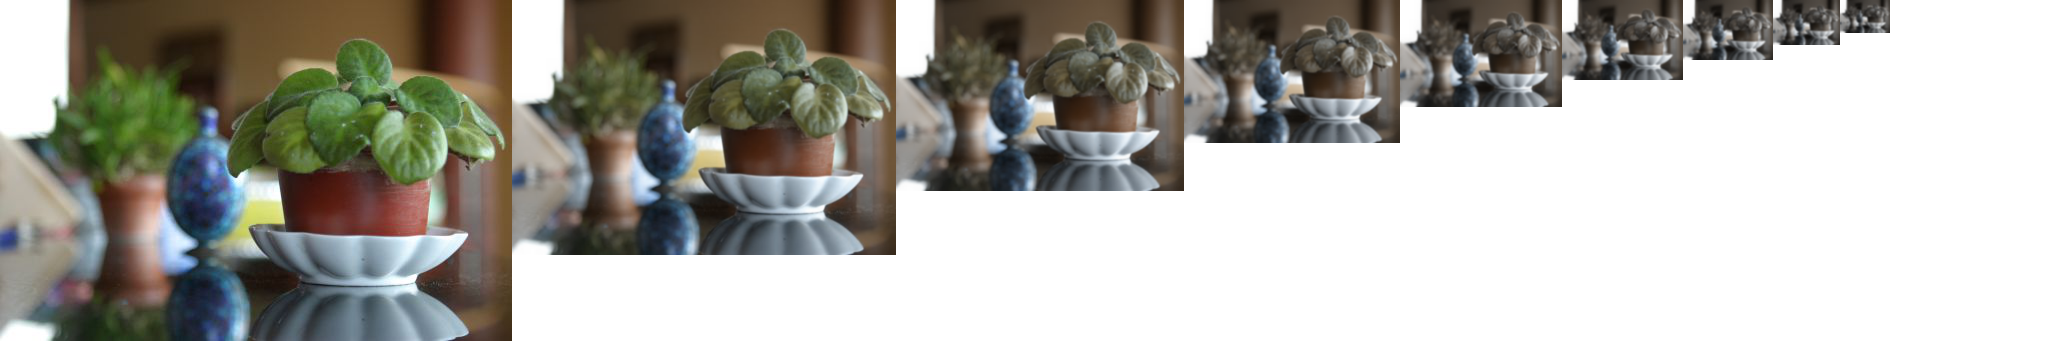

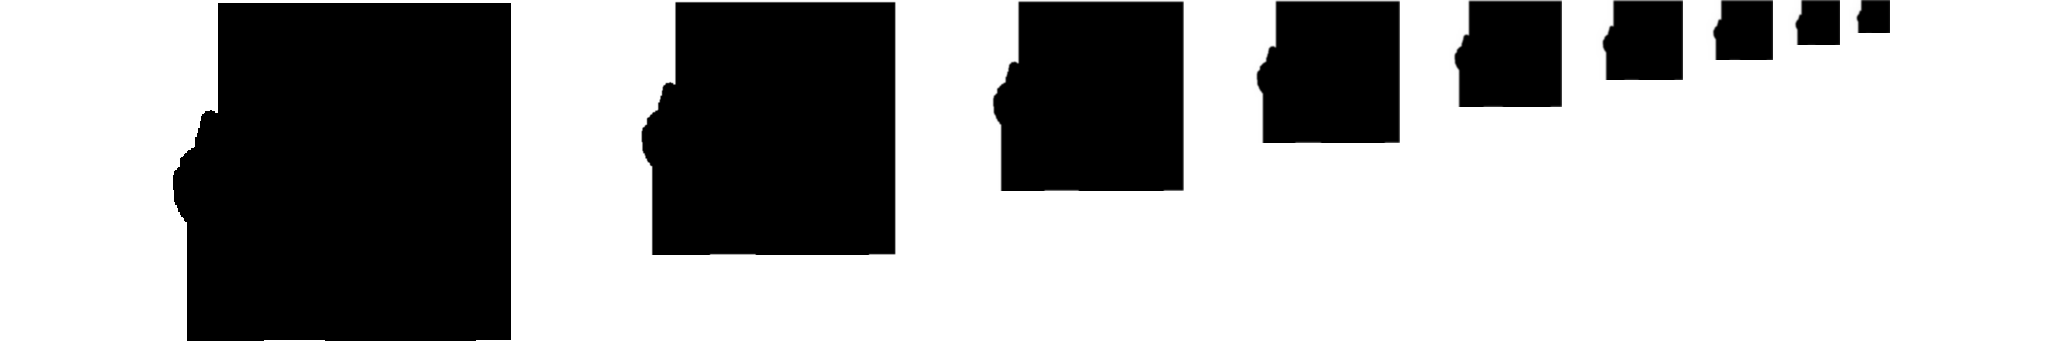

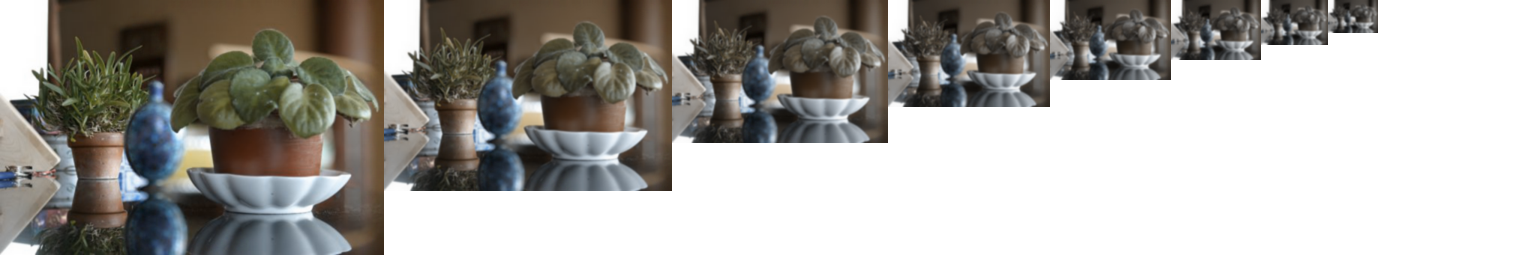

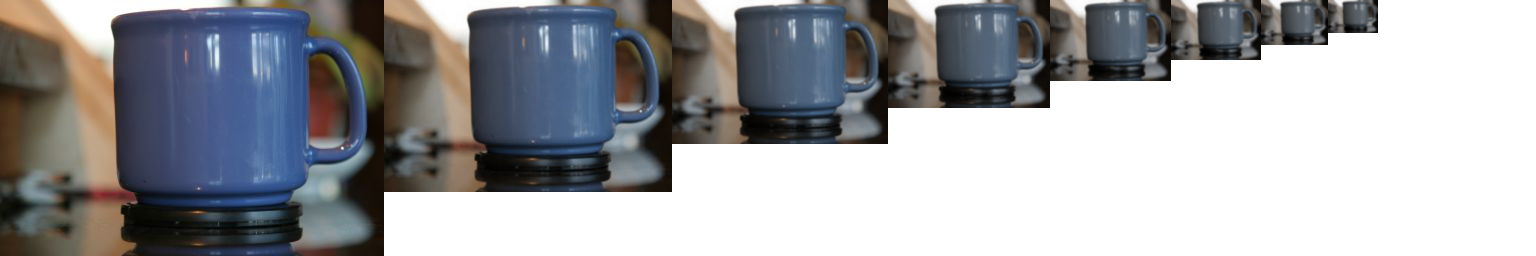

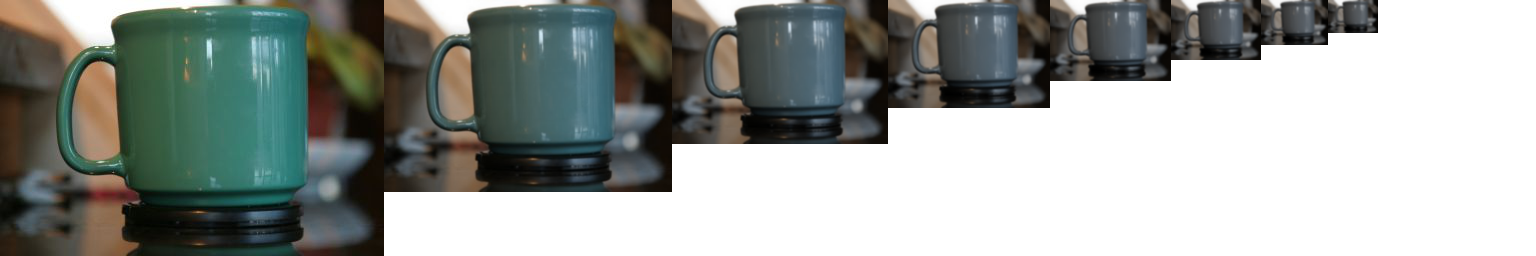

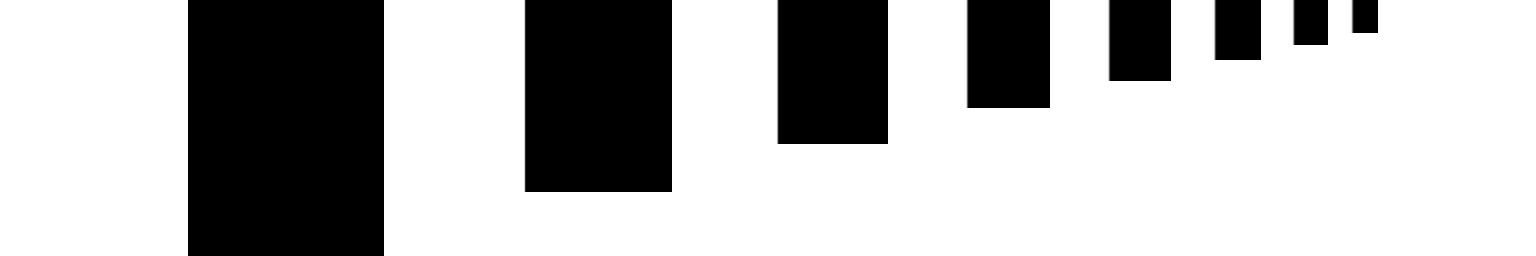

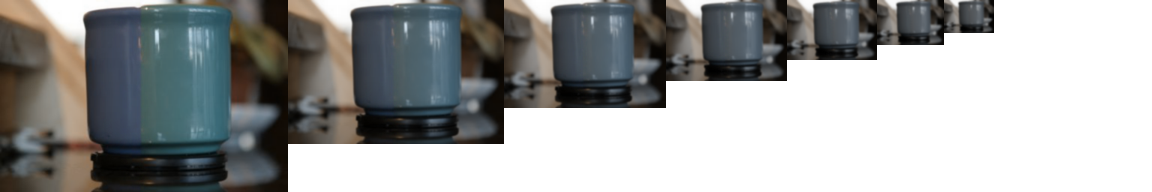

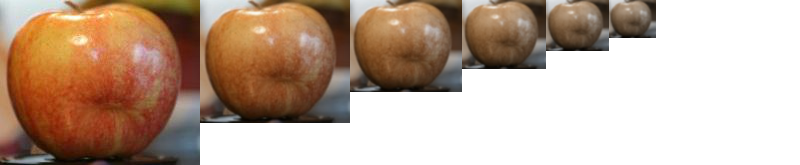

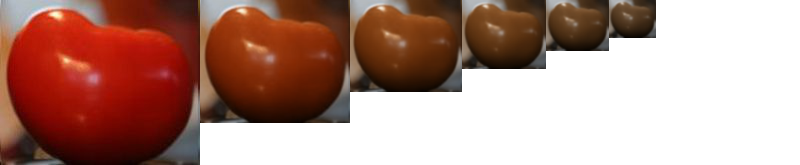

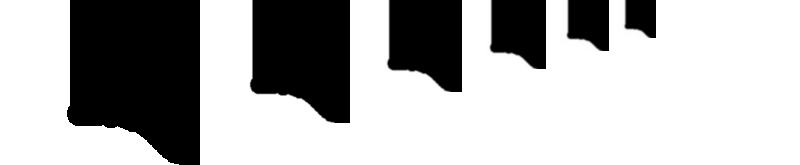

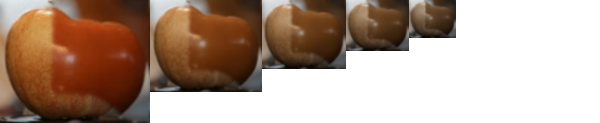

In [23]:
# 2.6
def blendImages(name1, name2, mask):
  test_images = [name1, name2]
  blends = []
  for name in test_images:
    im = Image.open(name + ".jpg")
    scale = 0.75
    minsize = 50
    blends.append(makeLaplacianPyramid(im, scale, minsize))

  # 2.5 (construct mask pyramid)
  im = Image.open(mask + ".bmp")
  scale = 0.75
  minsize = 50
  g_mask_pyramid = MakeGaussianPyramid(im, scale, minsize)
  showGaussianPyramid(g_mask_pyramid)

  compose = []
  for i in range(len(g_mask_pyramid)):
    mask_in_rgb = greyscaleToRGB(g_mask_pyramid[i])
    mask = PIL_to_arr(mask_in_rgb) / 255
    compose.append(blends[0][i] * (mask) + blends[1][i] * (1 - mask))

  reconstructGaussianFromLaplacianPyramid(compose)

blendImages("orchid", "violet", "orchid_mask")
#2.7
blendImages("blue_cup", "green_cup", "cup_mask")
blendImages("apple", "tomato", "tomato_mask")



In [45]:
!jupyter nbconvert --to PDF "Assign2.ipynb" #after mounting drive and navigate to the drive directory

[NbConvertApp] Converting notebook Assign2.ipynb to PDF
[NbConvertApp] Support files will be in Assign2_files/
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Making directory ./Assign2_files
[NbConvertApp] Writing 68409 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2872739 bytes to Assign2.pdf